# 复现文献：Lung-EffNet: Lung cancer classification using EfficientNet from CT-scan images

### why choose EfficientNet:
* EfficientNets are designed to achieve a good balance between model size and performance. They have shown superior efficiency in
terms of computational resources and memory requirements compared to other deep learning architectures
* In 2019, the Google AI research team proposed a family of EfficientNet series, namely EfficientNetB0–EfficienNetB7 (Tan and Le, 2019), as a backbone architecture that has outperformed many state-of-the-art deep CNN-based architectures such as Inception-V3, ResNet50, Inception-ResNetV2, DenseNet for image classification from ImageNet, segmentation, and other transfer learning based problems.
* One of the reasons for EfficientNetB1’s superior performance is its ability to extract features from the input images. EfficientNetB1 uses a combination of convolutional and pooling layers to extract features from the images, with each layer building on the features extracted by the
previous layer. This allows the model to learn complex representations of the images, which is crucial for accurate classification.

### EfficientNet B0-B7结构





### 一、数据集 “IQ-OTH/NCCD”
* 来源：Anon, 2023b. The IQ-OTH/NCCD lung cancer dataset — Kaggle. https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset

* In 2019, the dataset was collected from the “Iraq-Oncology Teaching Hospital and National Center for Cancer Diseases” for more than three months.
* The dataset was annotated by multiple oncologists and radiologists.
* The dataset consists of a total of 1097 images of a human chest representing CT scan slices of 110 cases varying in age, gender, education status, residence, and living status.

* The cases in this study were divided into three categories: benign, malignant, and normal
* Class          Patients     No. of samples
* Benign           15             120
* Malignant        40             561
* Normal           55             416
* Total            110            1097

#### 如何上传kaggle dataset
* 获取kaggle API 认证: A file named kaggle.json containing your username and API key will be downloaded.
* 设置google colab 使用kaggle API


In [2]:
# 挂载Google Drive： 如果文件确实存在于Google Drive中，
# 确保正确挂载了Google Drive到Colab。使用以下代码挂载Google Drive：
import os
import zipfile
from google.colab import drive
drive.mount('/content/drive')

# 解压文件到新建的文件夹中
with zipfile.ZipFile('/content/drive/MyDrive/datasets/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

print("文件已解压到:", os.path.abspath('/content/datasets'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
文件已解压到: /content/datasets


### 二、数据预处理
* 1、数据集划分：
* 所有1097张图像随机打乱，按80：20的比例分为训练集和测试集
  
* 2、图像裁剪：
* 1）去除原始CT扫描图像中不需要的区域：如背景和噪音可能会导致噪声训练，因此，通过从其余部分中裁剪出最大的肺轮廓的极值点来去除。
* 2）image size统一改为240 x 240 x 3, 使得满足预训练 EfficientNet models的输入形状
* **Image resizing also helps to reduce computational overload during model training by keeping contextual information and features in an image intact
* 3) 该文中并未提及归一化操作，因为EfficientNet包含了归一化层：Since the normalization layer is already present in the stem layer of EfficientNet therefore, no additional image normalization is required as a pre-processing step hence, it takes an input image with pixel intensity values in the range of 0–255。

* 3、class labels统一标记为0，1，2， 分别表示：benign, malignant, and normal

### 三、数据增强————有利于增加每种类型的数据样本；增加模型的稳健性防止模型过拟合。
* 本研究中对***训练集+验证集图像***采用6种数据增强技术：horizontal flip, rotation, brightness, zooming, width shift, and height shift
* 为了平衡每种类型样本量，benign, malignant, and normal classes的图像分别增加了13倍, 2倍和3倍（也就是样本量分别是原来的14倍，3倍和4倍）。因benign class 包含的图像最少，故增强最多。

* The class-wise distribution of the dataset after the train–test split of 80:20 ratio.
Class Split No. of sample Total
Benign Train 96 876
Malignant 448
Normal 332
Benign Test 24 221
Malignant 113
Normal 84

In [3]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.3 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=39d57bc4445597b18ecf9d20cd81f70fa2f8bb2edc66db9e

In [4]:
# 导入必要的库
import os
import cv2
import torch
import time
import numpy as np
from PIL import Image
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
from torch.optim.lr_scheduler import StepLR
from efficientnet_pytorch import EfficientNet
from torchvision import datasets, transforms
from sklearn.preprocessing import LabelEncoder # 用于标签编码
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, confusion_matrix

In [5]:
# 可视化图像
def imshow(inp,title=None):
  """
  Display image for Tensor.
  """
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

In [17]:
# OpenCV对图像裁剪处理，去除背景和噪声：get original image; find biggest contour; find the extrame points; crop the image
def crop_image(image):
  """
  OpenCV crop the image
  """
  # imshow(image)

  # check image PIL image
  if not isinstance(image, Image.Image):
    # convert tensor to PIL image
    if isinstance(image, torch.Tensor):
      image = transforms.ToPILImage()(image)
    else:
      print("image is not a torch.Tensor or PIL image object, so cropping the image is not effective")
      return image

  # convert PIL image to OpenCV format
  image_cv = np.array(image)
  if len(image_cv.shape) == 3:
    image_gray = cv2.cvtColor(image_cv,cv2.COLOR_RGB2GRAY)
  else:
    image_gray = image_cv

  # CV_32FC1 类型的图像先转换为 CV_8UC1 类型
  image_8u = cv2.convertScaleAbs(image_gray)

  # 二值化处理:在二值图像中，每个像素的值要么是 0（黑色），要么是 255（白色）
  _, binary = cv2.threshold(image_8u, 127, 255, cv2.THRESH_BINARY)

  # 查找轮廓:RETR_EXTERNAL 模式只检测外部轮廓，CHAIN_APPROX_SIMPLE 方法压缩轮廓点
  contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  if not contours:
    return image

  # 寻找最大轮廓
  biggest_contour = max(contours, key=cv2.contourArea)

  # 找到轮廓的极值点
  leftmost = tuple(biggest_contour[biggest_contour[:,:,0].argmin()][0])
  rightmost = tuple(biggest_contour[biggest_contour[:,:,0].argmax()][0])
  topmost = tuple(biggest_contour[biggest_contour[:,:,1].argmin()][0])
  bottommost = tuple(biggest_contour[biggest_contour[:,:,1].argmax()][0])

  # 裁剪图像:这四个元素依次代表裁剪区域左上角和右下角的坐标, 如leftmost[0] 提取的是该点(x, y)的 x 坐标，也就是裁剪区域左上角的 x 坐标。topmost[1] 提取的是该点的 y 坐标，即裁剪区域左上角的 y 坐标。
  cropped_image = image.crop((leftmost[0], topmost[1], rightmost[0], bottommost[1]))

  return cropped_image


# 加载数据集，不进行数据增强处理, 因不转换，故label为0，1，2.....
dataset = datasets.ImageFolder('/content/datasets/The IQ-OTHNCCD lung cancer dataset', transform=transforms.ToTensor())

# 获取所有样本和标签
all_images = []
all_labels = []
for image, label in dataset:
    all_images.append(image)
    all_labels.append(label)

print(len(all_images)) # 1097
class_names = dataset.classes # 数据集的类别名称列表
print(class_names)
print(set(all_labels)) # {0, 1, 2}

# 因ImageFolder 会自动按照字母顺序对类别文件夹排序，并将类别标签编码为从 0 开始的整数。
# 故benign, malignant, and normal对应的class label依次编码为0，1，2
# label_encoder = LabelEncoder()
# all_class_encoded = label_encoder.fit_transform(class_names)
# decoded_labels = label_encoder.inverse_transform(all_class_encoded)

# 对图像进行裁剪
cropped_images = []
for image in all_images:
  cropped_image = crop_image(image)
  cropped_images.append(cropped_image)

1097
['Bengin cases', 'Malignant cases', 'Normal cases']
{0, 1, 2}


Label:0,Number of images:97
Label:1,Number of images:446
Label:2,Number of images:334
训练数据增强后对应类别及图像数目
Counter({0: 1358, 1: 1338, 2: 1336})


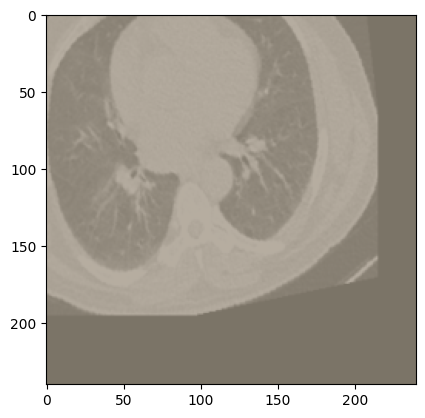

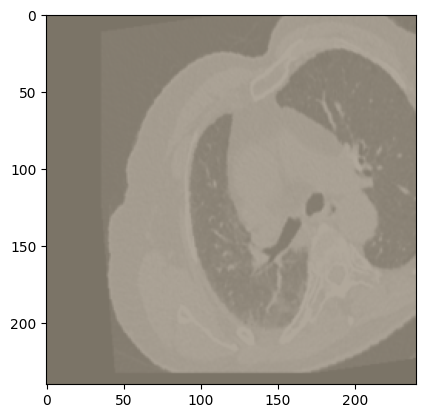

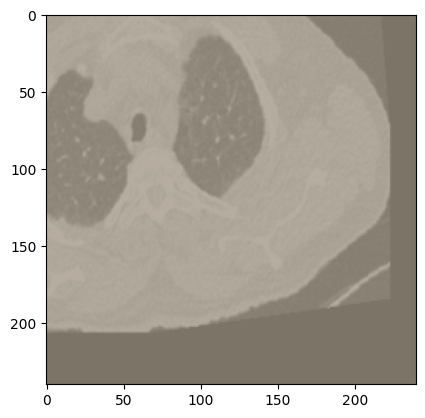

In [7]:
# train_test_split 划分数据集
#train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels_encoded, test_size=0.2, random_state=42)
train_images, test_images, train_labels, test_labels = train_test_split(cropped_images, all_labels, test_size=0.2, random_state=40)

# 数据增强和Resize
# translate 参数是一个元组 (tx, ty) ，tx 控制宽度方向平移比例（图像宽度的比例），ty 控制高度方向平移比例（图像高度的比例） ，取值范围通常在 [0, 1] 之间。
# 不包含标准化，因为EfficientNet中包含该部分
train_data_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0,translate=(0.2,0.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=(0.5, 1.5)),
        transforms.RandomResizedCrop(size=(240, 240), scale=(0.8, 1.2)),
        transforms.ToTensor()
    ])

test_data_transform = transforms.Compose([
        transforms.Resize((240,240)),
        transforms.ToTensor()
    ])

# 按类别分别进行增强：benign, malignant, and normal图像数目变为原来的14倍，3倍和4倍
#文献中使用factor = [14, 3, 4], 但train_test_split出的数目和文献中不同有些许差异 # 文献raw train: 0,1,2: 96, 448, 332
enhancement_factors = [14, 3, 4] # 0:1358	1:1338	2:1336
enhancement_train_images = []
enhancement_train_labels = []
for class_index in range(len(enhancement_factors)):
    class_images = [img for img, label in zip(train_images, train_labels) if label == class_index]  # 取出对应索引/类别的图片
    class_labels = [label for label in train_labels if label == class_index]  # 取出图片对应类别

    print("Label:{},Number of images:{}".format(class_index, len(class_images))) # Now train: 0,1,2: 97, 446, 334

    factor = enhancement_factors[class_index]
    for _ in range(factor):
        for img, label in zip(class_images, class_labels):
            #print(type(img)) # <class 'torch.Tensor'>
            #print(type(crop_image(img))) # <class 'numpy.ndarray'>
            enhanced_img = train_data_transform(img)
            enhancement_train_images.append(enhanced_img)
            enhancement_train_labels.append(label)

print("训练数据增强后对应类别及图像数目")
print(Counter(enhancement_train_labels)) # Counter({0: 1358, 1: 1338, 2: 1336})
# 展示部分增强后的图像
imshow(enhancement_train_images[0]);imshow(enhancement_train_images[1]);imshow(enhancement_train_images[2])

### 迁移学习
* 微调EfficientNet进行分类
* 基于5种预训练EfficientNet variations：i.e., EfficientNet B0–B4 are utilized as a backbone for the classification of lung cancer from the CT-scan slices；因EfficientNetB5-B7有更深的network和更多参数，所以模型可能对训练集过拟合，而且在训练模型的时候会产生较大的计算资源。(B0-B5最开始在ImageNet benchmark dataset训练)
* 选择最佳EfficientNet variations的标准：the dataset
size, the resources available for model training and evaluation, the depth of the model, the network parameters, and the batch size.

#### 1、微调预训练EfficientNetB1的方法：
* 为了降低维度，在预训练EfficientNetB1的分类层加入Global Average Pooling (GAP)，随后dropout(0.5)正则化防止模型过拟合, Dense(3)/output layers with 3 units with a Softmax activation layer替代原始的1000 units的输出层,每一个EfficientNet block层都保持不变。在不影响模型准确性性能情况下，加入GAP layer有助于简化许多参数的network

#### 2、超参数设置——batch size, optimizers, learning rate, epochs,and loss function
* loss function: 因分类任务，选择categorical cross-entropy作为
合适的loss function
* optimizers： 选择 Adam optimizer，初始学习率为0.001(1e-2)
* learning rate: decay factor of 0.3 was applied after evaluating the model’s validation accuracy at every 5 iterations
* 在不影响ImageNet权重情况下微调中引入正则化：drop connect rate of 0.2
* 输出层的激活函数：Softmax
* batch size: 32
* epoch: 50 epochs
* 每个epoch,将训练集的0.1随机分成一份验证集，验证集用于评估训练模型性能和是否发生过拟合。

In [8]:
### 加载数据集
# 创建自定义数据集类: torch.utils.data.Dataset 类是 PyTorch 提供的用于表示数据集的抽象类。当现有的数据集类无法满足特定需求时，可以通过继承 Dataset 类来创建自定义的数据集类，从而实现对数据的个性化加载、处理和访问。
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# 创建训练集和测试集
train_dataset = CustomDataset(enhancement_train_images, enhancement_train_labels, transform=None)
test_dataset = CustomDataset(test_images, test_labels, transform=test_data_transform)
print(len(train_dataset)) # 4032
print(len(test_dataset)) # 220

# 测试集每种类别数目
print(Counter(test_dataset.labels)) # Counter({1: 115, 2: 82, 0: 23})

# 从数据增强后的训练集中划分验证集
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
print(train_size, val_size) # 3628 404
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(0))

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # 使用的是数据增强后的训练集分割得到的，合理？
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

4032
220
Counter({1: 115, 2: 82, 0: 23})
3628 404


In [ ]:
### 训练模型并保存最佳模型
# 定义模型列表:efficientnet-b0 ~ efficientnet-b4
# 模型默认drop_connect_rate=0.2
# 加入GAP和dropout(0.5),output layer改成Dense(3) with softmax激活函数
# 设置模型其他层的不变，即添加模型其他层冻结

# 自定义一个Module来wrapper model.extract_features
class ExtractFeatureWrapper(nn.Module):
  def __init__(self, model):
    super(ExtractFeatureWrapper, self).__init__()
    self.model = model

  def forward(self, x):
    return self.model.extract_features(x)


# 绘制epoch对应的Loss图和Accuracy图
def loss_accuracy_plot(epoch_train_loss,epoch_train_acc,epoch_val_loss,epoch_val_acc,num_epochs,figurePath):
  """
  绘制epoch对应的Loss图和Accuracy图
  """
  plt.figure(figsize=(10, 6))
  epochs = range(1, num_epochs + 1)
  plt.plot(epochs, epoch_train_loss, label='Training Loss')
  plt.plot(epochs, epoch_val_loss, label='Validation Loss')
  plt.plot(epochs, epoch_train_acc, label='Training Accuracy')
  plt.plot(epochs, epoch_val_acc, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(rotation=45)
  plt.ylabel('Value')
  plt.title('Loss and Accuracy of Training and Validation')
  plt.legend()
  plt.tight_layout()
  plt.savefig(figurePath)
  plt.show()


def train_model(model, index, criterion, optimizer, scheduler, num_epochs=50):
  """
  训练模型,基于模型验证集acc最高，选择模型最佳参数
  """
  since = time.time()
  best_acc = 0.0

  # 保存模型每个epoch的训练集和验证集Loss和Accuracy
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for epoch in range(num_epochs):
    # 训练模型
    model.train()

    train_running_loss = 0.0
    train_running_total = 0
    train_running_corrects = 0

    for inputs, labels in train_loader:
      #for i, input_tensor in enumerate(inputs):
      #  print(f'Sample {i} shape: {input_tensor.shape}') # Sample 0 shape: torch.Size([3, 240, 240])
      #break

      # 梯度清零
      optimizer.zero_grad()

      # forward
      outputs = model(inputs)
      # outputs是模型对一批样本的预测结果，通过 torch.max(outputs, 1) 找出每个样本预测概率最大的类别索引，存储在 preds 中，然后与真实标签 labels 进行比较，计算预测正确的样本数量。
      _,preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)

      # backward + optimize
      loss.backward()
      optimizer.step()

      # statistic
      train_running_loss += loss.item() * inputs.size(0)
      train_running_total += inputs.size(0)
      tain_running_corrects += torch.sum(preds == labels.data)

    # 验证模型
    model.eval()

    val_running_loss = 0.0
    val_running_total = 0
    val_running_corrects = 0

    with torch.no_grad():
      for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        val_loss = criterion(outputs, labels)

        val_running_loss += val_loss.item() * labels.size(0)
        val_running_total += labels.size(0)
        val_running_corrects += (predicted == labels).sum().item()

    # 调整学习率:依据训练的轮次对学习率进行调整。
    scheduler.step()

    # 每个epoch训练集对应的loss和accuracy
    epoch_train_loss = train_running_loss / train_running_total
    epoch_train_accuracy = train_running_corrects / train_running_total

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # 每个epoch验证集对应的loss和accuracy
    epoch_val_loss = val_running_loss / val_running_total
    epoch_val_accuracy = val_running_corrects / val_running_total

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}:')
    print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy*100:.4f}%')
    print(f'Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy*100:.4f}%')
    print('-----' * 10)

    # model deepcopy
    if epoch_val_accuracy > best_acc:
      best_acc = epoch_val_accuracy
      #best_model_index = index

      # 保存训练好的模型参数
      tempdir="/content/drive/MyDrive/"
      best_model_params_path = os.path.join(tempdir,f'efficientnet-b{index}.{epoch + 1}.best_model_params.pt')
      torch.save(model.state_dict(), best_model_params_path)
      print(f'Best model efficientnet-b{index} saved at epoch {epoch + 1} with validation accuracy: {best_acc:.4f}%')

  # 耗时
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  #state_dict = model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
  #return state_dict

  return train_losses, train_accuracies, val_losses, val_accuracies

models = []
for i in range(5):
  model = EfficientNet.from_pretrained(f'efficientnet-b{i}', drop_connect_rate=0.2)

  # 冻结卷积层的权重
  for param in model.parameters():
    param.requires_grad = False

  # 插入Global Average Pooling (GAP) 层
  global_avg_pool = nn.AdaptiveAvgPool2d((1,1))
  dropout = nn.Dropout(0.5)
  output_layer = nn.Linear(model._fc.in_features, 3) # three class: 0,1,2
  softmax = nn.Softmax(dim=1)

  # 重新定义模型的结构
  model = nn.Sequential(
      ExtractFeatureWrapper(model),
      global_avg_pool,
      nn.Flatten(),
      dropout,
      output_layer,
      softmax
  )

  models.append(model)

# 定义损失函数
criterion = nn.CrossEntropyLoss()

for i, model in enumerate(models):
  # 定义优化器和学习率调整器
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  scheduler = StepLR(optimizer, step_size=5, gamma=0.3)

  # 训练模型
  num_epochs = 50
  train_losses, train_accuracies, val_losses, val_accuracies = train_model(model,i,criterion,optimizer,scheduler,num_epochs)

  # 绘制epoch对应的Loss图和Accuracy图
  figurePath=f"/content/drive/MyDrive/efficientnet-b{i}.epoch.Loss.Acc.plot.png"
  loss_accuracy_plot(train_losses,train_accuracies,val_losses,val_accuracies,num_epochs,figurePath)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 235MB/s]


Loaded pretrained weights for efficientnet-b0


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 59.0MB/s]


Loaded pretrained weights for efficientnet-b1


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 42.2MB/s]


Loaded pretrained weights for efficientnet-b2


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 104MB/s] 


Loaded pretrained weights for efficientnet-b3


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:01<00:00, 57.1MB/s]


Loaded pretrained weights for efficientnet-b4
Epoch 1/50:
Train Loss: 0.9235, Train Accuracy: 65.0772%
Val Loss: 0.9361, Val Accuracy: 65.8416%
--------------------------------------------------
Best model efficientnet-b0 saved at epoch 1 with validation accuracy: 65.8416%
Epoch 2/50:
Train Loss: 0.8437, Train Accuracy: 72.1334%
Val Loss: 0.8792, Val Accuracy: 69.0594%
--------------------------------------------------
Best model efficientnet-b0 saved at epoch 2 with validation accuracy: 69.0594%
Epoch 3/50:
Train Loss: 0.8214, Train Accuracy: 74.3660%
Val Loss: 0.8590, Val Accuracy: 68.8119%
--------------------------------------------------
Epoch 4/50:
Train Loss: 0.8142, Train Accuracy: 74.4763%
Val Loss: 0.8464, Val Accuracy: 69.3069%
--------------------------------------------------
Best model efficientnet-b0 saved at epoch 4 with validation accuracy: 69.3069%
Epoch 5/50:
Train Loss: 0.7957, Train Accuracy: 77.3705%
Val Loss: 0.8397, Val Accuracy: 72.2772%
-----------------------

### 微调模型性能评估
#### 1、该研究中使用的深度学习模型性能评估方法：accuracy, F1-Score, precision, recall/sensitivity, ROC curve, and confusion matrix
* TP, TN, FP, and FN stand for true positive, true negative, false positive, and false negative respectively.
* Accuracy = (TP + TN) / (TP + TN + FP + FN)
* Precision = TP / (TP + FP) # 正确阳性的比例
* Recall = TP / (TP + FN) # 正确识别的实际阳性的比例
* F1-Score = 2 x Precision x Recall / (Precision + Recall)
* ROC curve: True Positive rate (TPR) & False Positive rate (FPR)
* TPR = TP / (TP + FN) # recall/sensitivity 纵坐标
* FPR = FP / (FP + TN) # 1-specificity 横坐标
* specificity = TNR = TN / (FP + TN) = 1-FPR
* Confusion matrix:总结模型整体性能

#### 2、Comparative analysis of Lung-EffNet with previous state-of-the-art approaches
* Lung-EffNet: be highly efficient and generalized than conventional ML algorithms such as SVM and RF, and other
DL-based CNN architectures such as VGG16, ResNet50, and DenseNet121

Loaded pretrained weights for efficientnet-b0
Test Loss: 0.7301, Test Accuracy: 83.64%
Test F1-Score: 0.8426, Test Precision: 0.8671, Test Recall: 0.8364


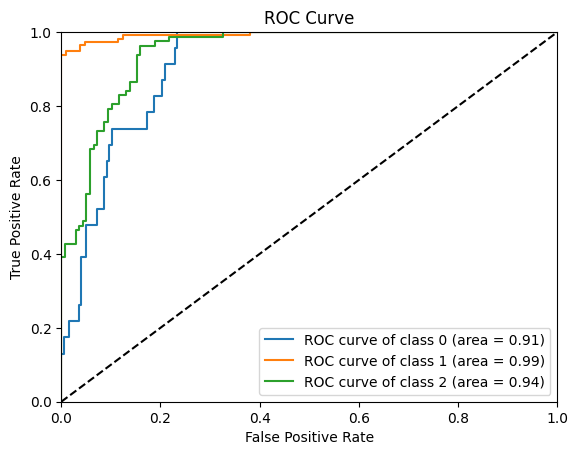

Test Confusion Matrix:
[[ 17   0   6]
 [  1 112   2]
 [ 21   6  55]]


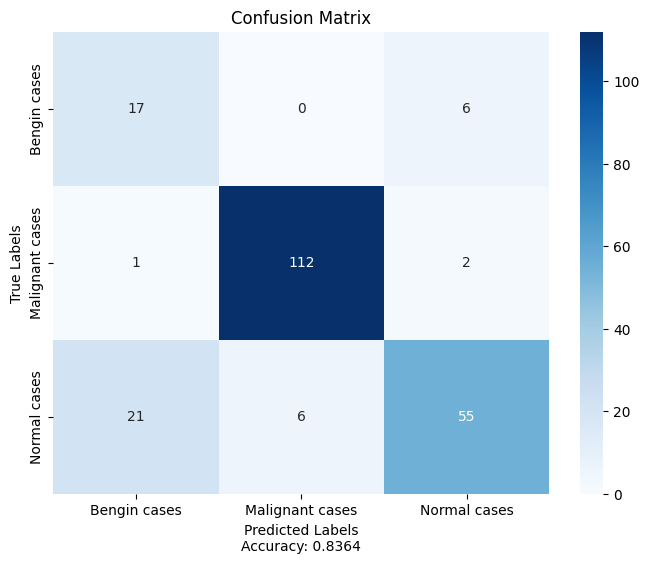

In [21]:
### 基于训练模型b1验证集acc最高，故后续基于训练好的b1模型进行评估
### 测试集评估最佳模型
def draw_ROC(test_all_labels,test_all_probs,figurePath):
  """
  绘制测试集ROC曲线（不同类别）
  """
  test_all_labels = np.array(test_all_labels)
  test_all_probs = np.array(test_all_probs)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_all_labels,test_all_probs[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure()
  for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
  plt.plot([0,1],[0,1],'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc='lower right')
  plt.savefig(figurePath)
  plt.show()


#best_model_index = 1
best_model_index = 0

# 加载最佳模型b1
best_model_name = f'efficientnet-b{best_model_index}'
best_model = EfficientNet.from_pretrained(best_model_name, drop_connect_rate=0.2)
best_model = nn.Sequential(
    ExtractFeatureWrapper(best_model),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(best_model._fc.in_features, 3),
    nn.Softmax(dim=1)
)

#best_model.load_state_dict(torch.load('/content/drive/MyDrive/efficientnet-b{best_model_index}.best_model_params.pt'))
# 测试代码
best_model.load_state_dict(torch.load('/content/drive/MyDrive/efficientnet-b0.12.best_model_params.pt'))
best_model.eval()

# 测试最佳模型
test_all_labels = []
test_all_preds = []
test_all_probs = []

test_running_loss = 0.0
test_running_total = 0
test_running_correct = 0

with torch.no_grad():
  for inputs, labels in test_loader:
    outputs = best_model(inputs)
    test_loss = criterion(outputs, labels)
    test_running_loss += test_loss.item() * labels.size(0)

    _,predicted = torch.max(outputs, 1)
    test_running_total += labels.size(0)
    test_running_correct += (predicted == labels).sum().item()

    test_all_labels.extend(labels.numpy())
    test_all_preds.extend(predicted.numpy())
    test_all_probs.extend(outputs.numpy())

test_loss = test_running_loss / test_running_total
test_accuracy = test_running_correct / test_running_total

# average='weighted':多分类问题中，不同类别的样本数量可能不同，加权平均会考虑每个类别的样本数量，为每个类别分配一个权重，然后计算加权后的 F1 分数。这样可以更公平地评估模型在各个类别上的性能。
test_f1 = f1_score(test_all_labels,test_all_preds,average='weighted')
test_precision = precision_score(test_all_labels,test_all_preds,average='weighted')
test_recall = recall_score(test_all_labels,test_all_preds,average='weighted')

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test F1-Score: {test_f1:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}')

# ROC
rocPath=f"/content/drive/MyDrive/{best_model_name}.test.ROC.png"
draw_ROC(test_all_labels,test_all_probs,rocPath)

# confusion matrix
class_name = dataset.classes # ['Benign','Malignant','Normal']
test_conf_matrix = confusion_matrix(test_all_labels, test_all_preds)
print(f'Test Confusion Matrix:\n{test_conf_matrix}')

conmat=f"/content/drive/MyDrive/{best_model_name}.test.confusion_matrix.png"
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=class_name, yticklabels=class_name)
plt.xlabel(f'Predicted Labels\nAccuracy: {test_accuracy:.4f}')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig(conmat)
plt.show()

### 消融实验Ablation study
* 为了评估Lung-Effnet在肺癌分类的泛化性和稳健性，作者针对部分关键参数进行消融实验。
* 探究不同因素对模型性能的影响，及其在不同条件下的作用
* 主要包含：
* 1）计算复杂度：随着微调B0-B4模型深度的增加，参数数目也在增加，表明更高的复杂结构
* 2）数据增强技术的影响：通过比较微调B0-B4模型使用数据增强和非数据增强的结果，发现：数据增强后，模型结果更优。
* 3）数据集分割比例的影响：将数据集分别按照80：20， 70：30， 90：10的比例划分，发现：80:20分割相比其他分割要好，表明在利用迁移学习的情况下，使用更小的训练集确实可以在分类精度和整体性能方面产生有利的结果；同时，通过分配80%的数据集为训练集，为模型的学习和泛化提供了充足的数据，有助于防止过拟合。
* 4）模型是否进行迁移学习的比较：EfficientNets结合迁移学习更有利于增强模型的泛化性能；基于大量的影像数据重新训练深度学习网络计算昂贵和耗时，通过迁移学习能显著减少训练时间和计算资源。
* 5）训练模型用于不同肺癌类型的分类：Anon, 2023a. Chest CT-Scan images Dataset. Available: Chest CT-scan images dataset. htt
ps://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images. (Accessed
07 June 2023). 将数据集按70：10：20的比例分割数据为训练集、验证集和测试集。针对此数据不进行数据增强操作（便于更好的分析和强调模型的鲁棒性），class包含4类：0，1，2，3 分别对应：normal,
adenocarcinoma, large cell carcinoma, and squamous cell carcinoma，输出层设置为4，其他参数和之前相同。

### ONNIX部署